This code defines the cubic model, $$f(x;\theta) = q_1 + q_2 x + q_3 x^2 + q_4 x^3$$, and then calculates a finite difference approximation of the model sensitivity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import t


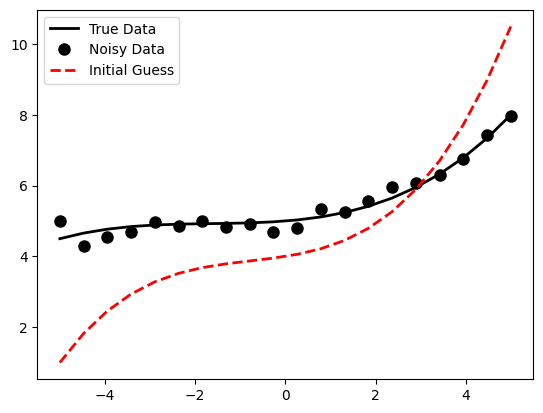

In [3]:

# Define the cubic model
def cubic_model(q, x):
    return q[0] + q[1] * x + q[2] * x**2 + q[3] * x**3

# Parameters
param_star = [5, 0.1, 0.05, 0.01]
param_guess = [4, 0.2, 0.07, 0.03]

# Generate data
xspace = np.linspace(-5, 5, 20)
true_data = cubic_model(param_star, xspace)
noisy_data = true_data + np.random.normal(0, 0.2, len(xspace))
initial_guess = cubic_model(param_guess, xspace)

# Plot initial data and guesses
plt.figure()
plt.clf()
plt.plot(xspace, true_data, '-k', linewidth=2, label='True Data')
plt.plot(xspace, noisy_data, 'ko', markersize=8, label='Noisy Data')
plt.plot(xspace, initial_guess, '--r', linewidth=2, label='Initial Guess')
plt.legend()
plt.show()


Final estimate:
[4.9760281  0.17441111 0.05284486 0.0061066 ]
True value:
[5, 0.1, 0.05, 0.01]


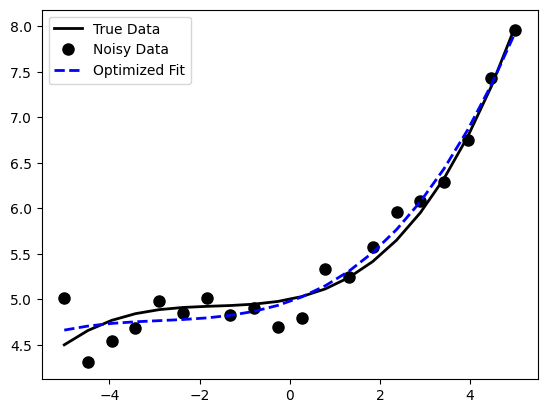

In [4]:
# Define the cost function
def get_cubic_cost(q, xspace, data):
    sim = cubic_model(q, xspace)
    residual = data - sim
    return np.sum(residual**2)

# Perform optimization
result = minimize(get_cubic_cost, param_guess, args=(xspace, noisy_data))
param_opt = result.x

print('Final estimate:')
print(param_opt)
print('True value:')
print(param_star)

# Plot optimized fit
plt.figure()
plt.plot(xspace, true_data, '-k', linewidth=2, label='True Data')
plt.plot(xspace, noisy_data, 'ko', markersize=8, label='Noisy Data')
plt.plot(xspace, cubic_model(param_opt, xspace), '--b', linewidth=2, label='Optimized Fit')
plt.legend()
plt.show()

Parameter CI:
[[4.83178754e+00 5.12026867e+00]
 [9.46597129e-02 2.54162512e-01]
 [4.11527304e-02 6.45369869e-02]
 [1.67560623e-03 1.05376023e-02]]
[5, 0.1, 0.05, 0.01]


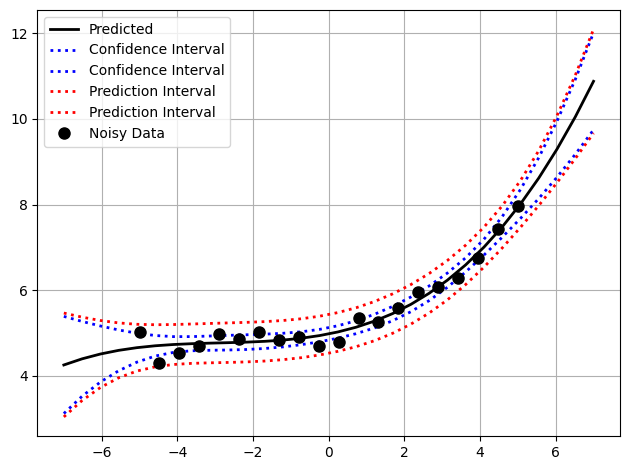

In [6]:
# Construct confidence intervals
X_des = np.vstack([np.ones(len(xspace)), xspace, xspace**2, xspace**3]).T
res = noisy_data - cubic_model(param_opt, xspace)
s2 = np.sum(res**2) / (len(xspace) - len(param_opt))
covar = s2 * np.linalg.inv(X_des.T @ X_des)


CI_plus = param_opt + t.ppf(0.975, len(xspace)-len(param_opt)) * np.sqrt(np.diag(covar))
CI_minus = param_opt - t.ppf(0.975, len(xspace)-len(param_opt)) * np.sqrt(np.diag(covar))

print('Parameter CI:')
print(np.vstack((CI_minus, CI_plus)).T)
print(param_star)

# Construct prediction intervals
x_test = np.linspace(-7, 7, 30)
X_test_des = np.vstack([np.ones(len(x_test)), x_test, x_test**2, x_test**3]).T
Y_pred = cubic_model(param_opt, x_test)

Y_CI = np.zeros((len(x_test), 2))
Y_PI = np.zeros((len(x_test), 2))

for i in range(len(x_test)):
    SE_pred = np.sqrt(X_test_des[i, :] @ covar @ X_test_des[i, :].T)
    Y_CI[i, 0] = Y_pred[i] + t.ppf(0.975, len(xspace)-len(param_opt)) * SE_pred
    Y_CI[i, 1] = Y_pred[i] - t.ppf(0.975, len(xspace)-len(param_opt)) * SE_pred
    Y_PI[i, 0] = Y_pred[i] + t.ppf(0.975, len(xspace)-len(param_opt)) * np.sqrt(s2 + SE_pred**2)
    Y_PI[i, 1] = Y_pred[i] - t.ppf(0.975, len(xspace)-len(param_opt)) * np.sqrt(s2 + SE_pred**2)

plt.figure(2)
plt.clf()
plt.plot(x_test, Y_pred, '-k', linewidth=2, label='Predicted')
plt.plot(x_test, Y_CI, ':b', linewidth=2, label='Confidence Interval')
plt.plot(x_test, Y_PI, ':r', linewidth=2, label='Prediction Interval')
plt.plot(xspace, noisy_data, 'ko', markersize=8, label='Noisy Data')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

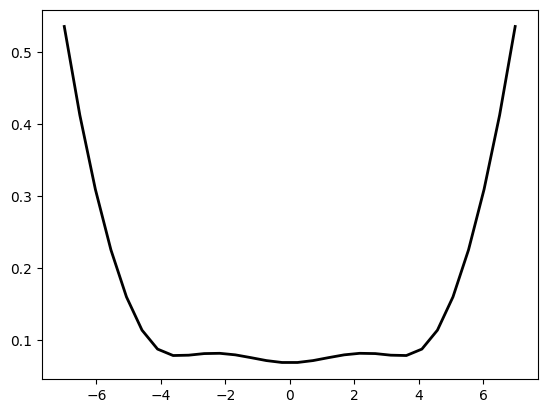

In [8]:
test = np.zeros((30,1))
for i in range(len(x_test)):
    test[i] = np.sqrt(X_test_des[i, :] @ covar @ X_test_des[i, :].T)
plt.figure(3)
plt.clf()
plt.plot(x_test, test, '-k', linewidth=2, label='Predicted')